In [1]:
import tensorflow as tf
import keras
import keras_vggface
from keras_vggface.vggface import VGGFace
# Had to change code in keras vggface to make it work changed model.py line 20 as shown here https://stackoverflow.com/a/71379206
import numpy as np
import matplotlib as mpl
from keras.utils.data_utils import get_file
import keras_vggface.utils
import PIL
import os
import os.path
import matplotlib.pyplot as plt

In [4]:
train_seed = 42
split = 0.2

train_dataset = keras.utils.image_dataset_from_directory('./AIGroupFaces', shuffle=True, image_size=(224, 224), batch_size=8, seed=train_seed, validation_split=split, subset='training')
val_dataset = keras.utils.image_dataset_from_directory('./AIGroupFaces', shuffle=True, image_size=(224, 224), batch_size=8, seed=train_seed, validation_split=split, subset='validation')

Found 300 files belonging to 4 classes.
Using 240 files for training.
Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

Found 300 files belonging to 4 classes.
Using 60 files for validation.


2023-05-10 21:12:32.581847: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-10 21:12:32.582056: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.2), ])

In [8]:
resnet_base = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3))

In [34]:
from keras.layers import Dense, Flatten, Input
from keras_vggface.vggface import VGGFace

num_classes = 4

resnet_base.trainable = False
last_layer = resnet_base.get_layer('avg_pool').output

inputs = tf.keras.Input(shape=(224, 224, 3))

x = data_augmentation(inputs)
x = resnet_base(x)
x = Flatten(name='flatten')(x)

out = Dense(num_classes, name='classifier')(x)

custom_resnet_model = keras.Model(inputs, out)

In [35]:
LR = 0.0001

custom_resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [36]:
base_history = custom_resnet_model.fit(train_dataset, epochs=20, validation_data=val_dataset)

Epoch 1/20


2023-05-03 15:20:19.065306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - ETA: 0s - loss: 2.2021 - accuracy: 0.2708

2023-05-03 15:20:22.314624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 6s 242ms/step - loss: 2.2021 - accuracy: 0.2708 - val_loss: 1.4763 - val_accuracy: 0.4667
Epoch 2/20
15/15 [==============================] - 2s 158ms/step - loss: 1.2168 - accuracy: 0.5625 - val_loss: 0.7700 - val_accuracy: 0.7500
Epoch 3/20
15/15 [==============================] - 2s 153ms/step - loss: 0.8384 - accuracy: 0.7083 - val_loss: 0.5299 - val_accuracy: 0.8000
Epoch 4/20
15/15 [==============================] - 2s 154ms/step - loss: 0.6992 - accuracy: 0.7958 - val_loss: 0.3662 - val_accuracy: 0.9333
Epoch 5/20
15/15 [==============================] - 2s 156ms/step - loss: 0.6746 - accuracy: 0.7667 - val_loss: 0.3096 - val_accuracy: 0.9333
Epoch 6/20
15/15 [==============================] - 2s 152ms/step - loss: 0.5795 - accuracy: 0.8083 - val_loss: 0.2793 - val_accuracy: 0.9333
Epoch 7/20
15/15 [==============================] - 2s 152ms/step - loss: 0.6142 - accuracy: 0.7875 - val_loss: 0.2524 - val_accuracy: 0.9333
Epoch 8/20
15/15 

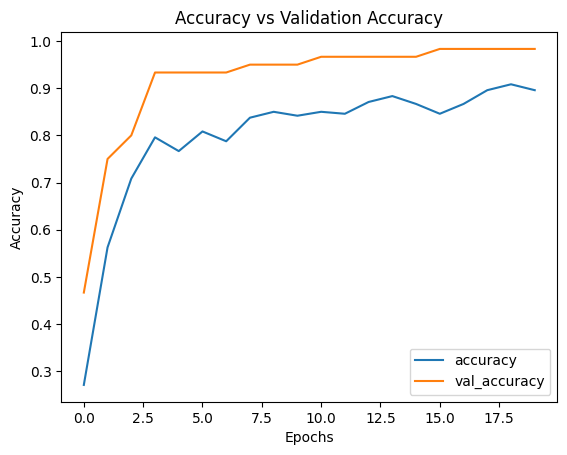

In [37]:
plt.plot(base_history.history['accuracy'], label='accuracy')
plt.plot(base_history.history['val_accuracy'], label='val_accuracy')

plt.title("Accuracy vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Privacy

In [5]:
from tensorflow_privacy.privacy.optimizers.dp_optimizer import DPGradientDescentGaussianOptimizer
import tensorflow_privacy

In [9]:
train_dataset = keras.utils.image_dataset_from_directory('./AIGroupFaces', shuffle=True, image_size=(224, 224), batch_size=16, seed=train_seed, validation_split=split, subset='training')
val_dataset = keras.utils.image_dataset_from_directory('./AIGroupFaces', shuffle=True, image_size=(224, 224), batch_size=16, seed=train_seed, validation_split=split, subset='validation')

Found 300 files belonging to 4 classes.
Using 240 files for training.
Found 300 files belonging to 4 classes.
Using 60 files for validation.


In [12]:
from keras.layers import Dense, Flatten, Input
from keras_vggface.vggface import VGGFace

num_classes = 4

resnet_base.trainable = False
last_layer = resnet_base.get_layer('avg_pool').output

inputs = tf.keras.Input(shape=(224, 224, 3))

x = data_augmentation(inputs)
x = resnet_base(x)
x = Flatten(name='flatten')(x)

out = Dense(num_classes, name='classifier', activation='softmax')(x)

custom_resnet_model = keras.Model(inputs, out)

In [13]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction=tf.losses.Reduction.NONE)

In [14]:
noise_multiplier = 1.1
l2_norm_clip = 3
num_microbatches = 16
learning_rate = 0.0001


optimizer = tensorflow_privacy.DPKerasAdamOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate
)

In [15]:
LR = 0.0001

custom_resnet_model.compile(optimizer=optimizer,
    loss = loss,
    metrics=['accuracy'])

In [27]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
history = custom_resnet_model.fit(train_dataset, epochs=20, validation_data=val_dataset)

Epoch 1/20
15/15 [==============================] - 3s 183ms/step - loss: 1.6457 - accuracy: 0.6208 - val_loss: 1.8544 - val_accuracy: 0.5667
Epoch 2/20
15/15 [==============================] - 3s 185ms/step - loss: 1.7727 - accuracy: 0.6292 - val_loss: 1.8608 - val_accuracy: 0.5667
Epoch 3/20
15/15 [==============================] - 3s 183ms/step - loss: 1.7103 - accuracy: 0.6292 - val_loss: 1.8643 - val_accuracy: 0.5667
Epoch 4/20
15/15 [==============================] - 3s 184ms/step - loss: 1.7904 - accuracy: 0.6208 - val_loss: 1.9587 - val_accuracy: 0.5500
Epoch 5/20
15/15 [==============================] - 3s 185ms/step - loss: 1.3818 - accuracy: 0.6292 - val_loss: 1.9172 - val_accuracy: 0.5500
Epoch 6/20
15/15 [==============================] - 3s 189ms/step - loss: 1.5255 - accuracy: 0.6417 - val_loss: 2.0099 - val_accuracy: 0.5500
Epoch 7/20
15/15 [==============================] - 3s 190ms/step - loss: 1.5985 - accuracy: 0.6417 - val_loss: 2.1077 - val_accuracy: 0.5333
Epoch 

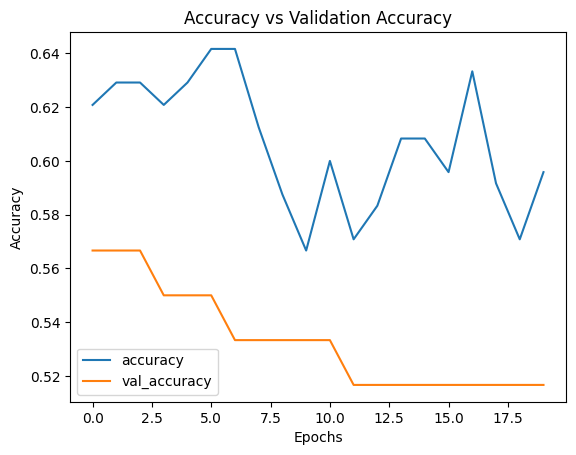

In [28]:

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')

plt.title("Accuracy vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [34]:
tensorflow_privacy.compute_dp_sgd_privacy(240, 16, 1.1, 20, 1e-5)

DP-SGD with sampling rate = 6.67% and noise_multiplier = 1.1 iterated over 300 steps satisfies differential privacy with eps = 7.32 and delta = 1e-05.
The optimal RDP order is 3.5.


(7.3234449845072, 3.5)